In [46]:
using Revise, Plots, FFTW, LinearAlgebra, LaTeXStrings, Random, Distributions

In [47]:
includet("../../src/SparseSpikes.jl")
using .SparseSpikes

Define ground truth amplitudes and positions

In [48]:
# Define the number of Fourier coefficients
fc = 6
n = 2fc + 1

# Define noise level
noise_level = 0

# Seed for noise
Random.seed!(12)

TaskLocalRNG()

In [49]:
domain = [0, 1]

# Seperation
C = 0.62 #eta0 = etaV
# C = 0.48 #eta0 != etaV
Δ = C/fc

x0 = [0.5-.5Δ, 0.5+.5Δ]
a0 = [1.0, -1.0]

μ0 = DiscreteMeasure(x0, a0)

DiscreteMeasure([0.44833333333333336, 0.5516666666666666], [1.0, -1.0], 1, 2)

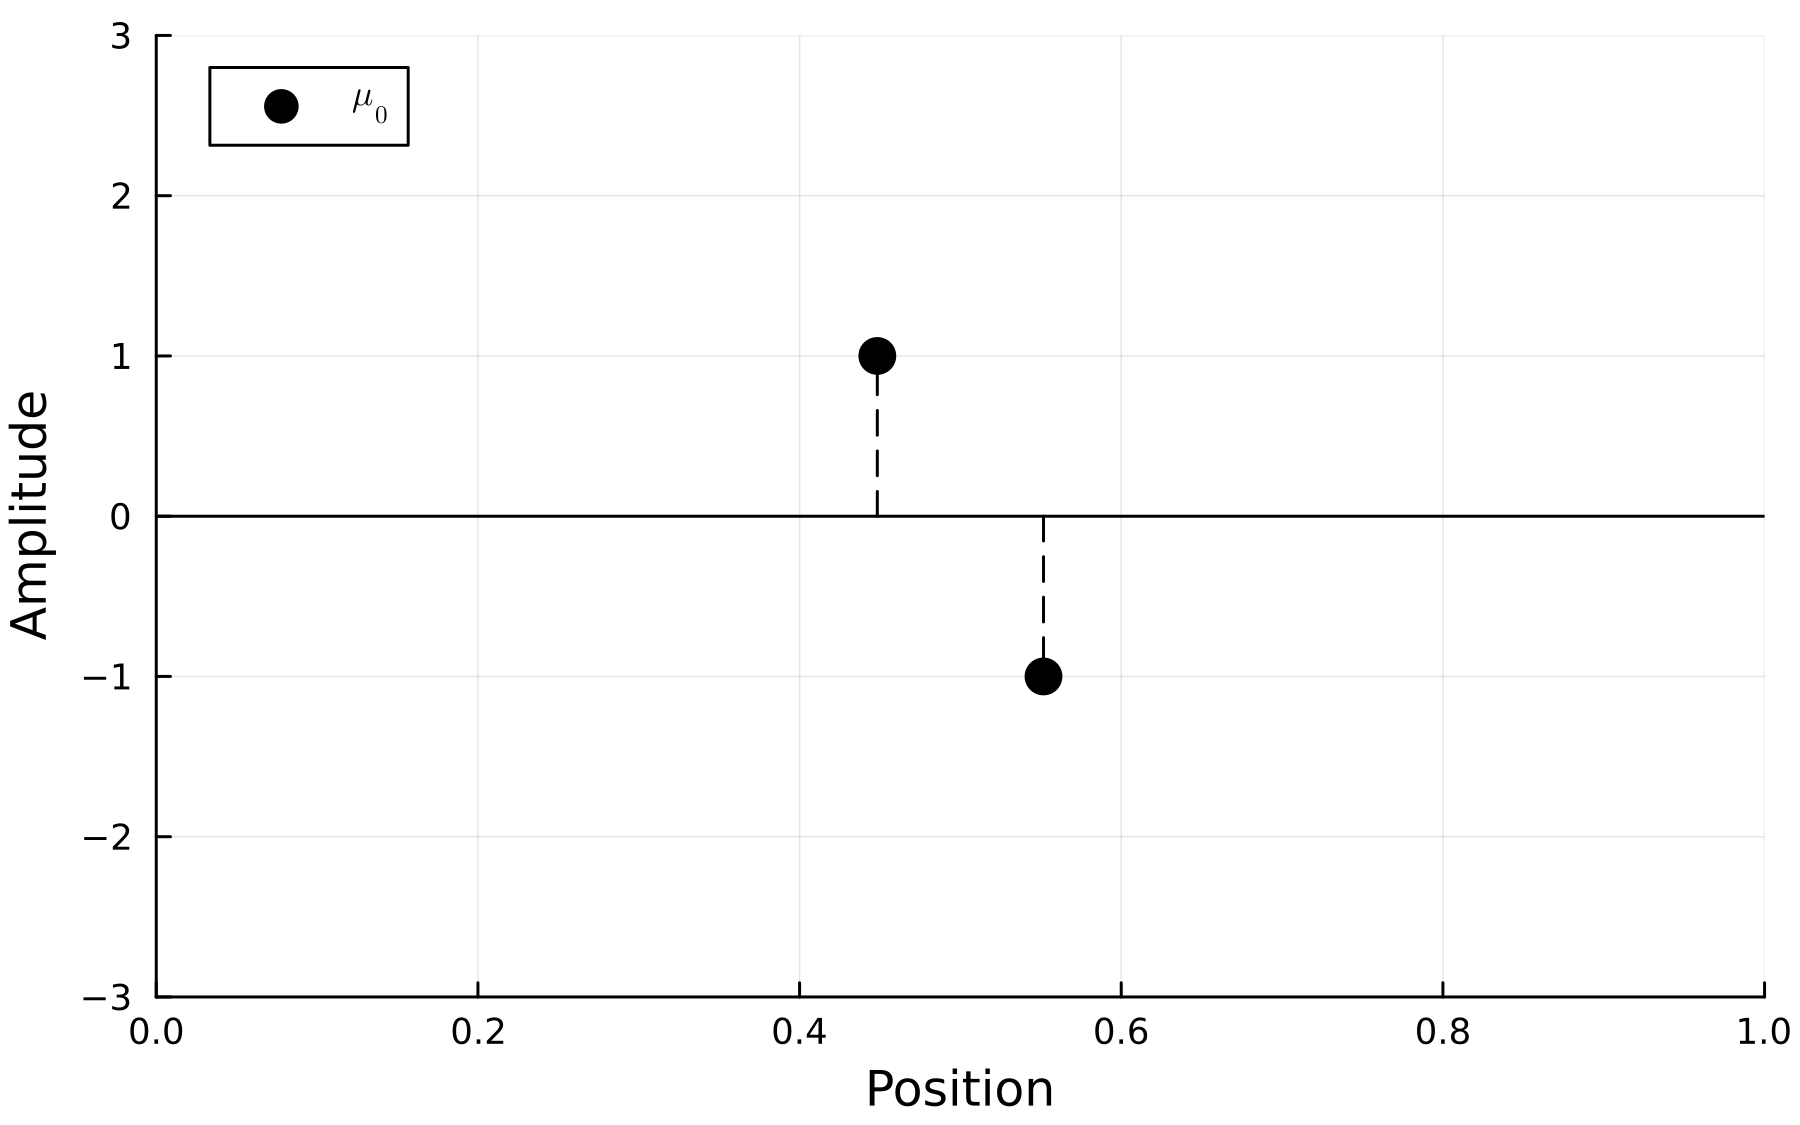

In [50]:
# Define the plot
num_points = 1000
plt_grid = range(domain..., length=(num_points + 1))
plot_size = (400, 250) .* 1.5
plt = plot(xlims=extrema(domain), ylims=(-3, 3), xlabel="Position", ylabel="Amplitude", legend=:topright, size=plot_size, dpi=300)
hline!(plt, [0], linestyle=:solid, color=:black, label="", legendposition=:topleft)

# plot!(plt, μ0.x, μ0.a, seriestype=:scatter, color=:yellow, label=L"μ_0", marker=:square, markersize=5, markerstrokewidth=2)
plot!(plt, μ0.x, μ0.a, seriestype=:scatter, color=:black, label=L"μ_0", marker=:circle, markersize=7, markerstrokewidth=0)
for (xi, ai) in zip(μ0.x, μ0.a)
    plot!(plt, [xi, xi], [0, ai], linestyle=:dash, color=:black, label="")
end
plt

In [51]:
ops = fourier_operators_1D(fc, plt_grid)

Operators(var"#ϕ#12"{Float64, UnitRange{Int64}}(0.2773500981126146, -6:6), var"#Φ#13"{var"#ϕ#12"{Float64, UnitRange{Int64}}}(var"#ϕ#12"{Float64, UnitRange{Int64}}(0.2773500981126146, -6:6)), var"#adjΦ#14"{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, var"#adjΦ#11#15"{var"#ϕ#12"{Float64, UnitRange{Int64}}}}(0.0:0.001:1.0, var"#adjΦ#11#15"{var"#ϕ#12"{Float64, UnitRange{Int64}}}(var"#ϕ#12"{Float64, UnitRange{Int64}}(0.2773500981126146, -6:6))))

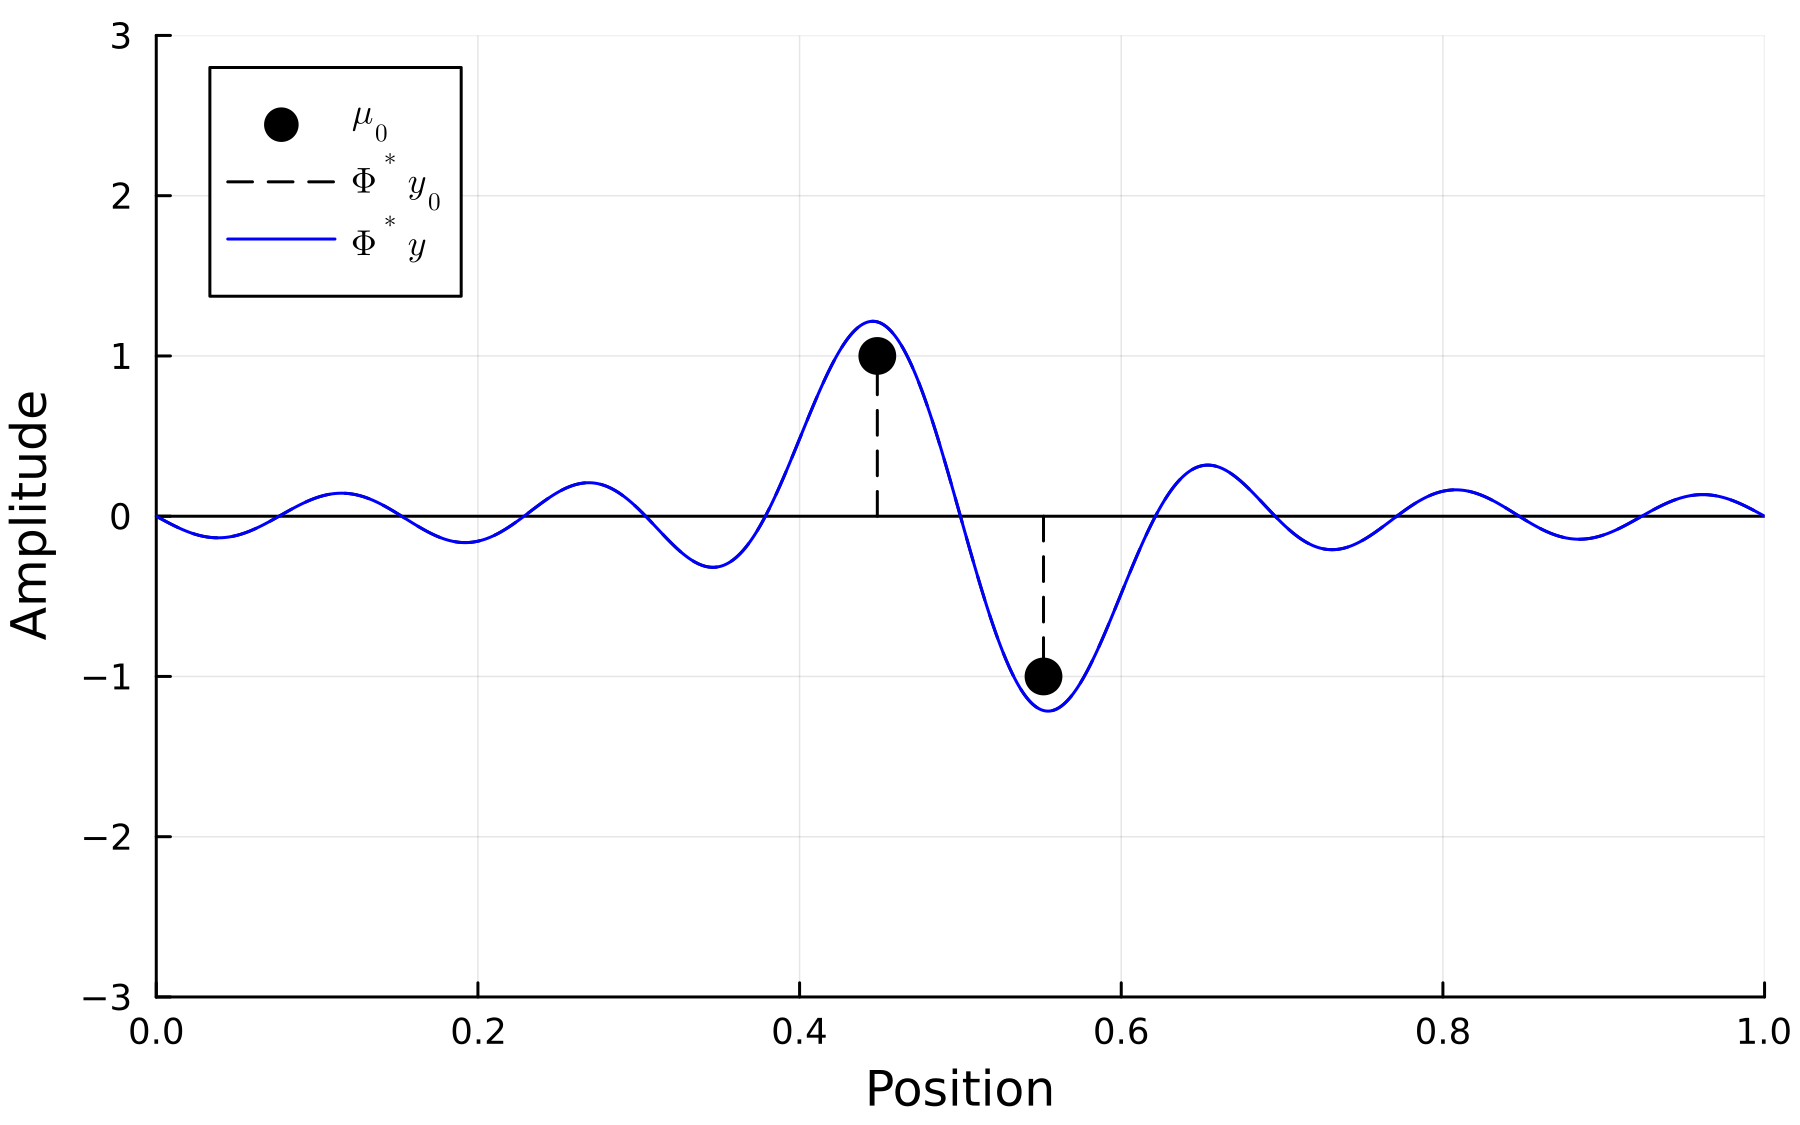

In [ ]:
# Calculate the observation y0 = Φμ0
y0 = ops.Φ(x0, a0)

# Add noise to the observation y = y0 + w
sigma = noise_level * norm(y0)
w = fftshift(fft(randn(length(y0))))
w = w / norm(w) * sigma
y = y0 + w

plt_obs = deepcopy(plt)

plot!(plt_obs, plt_grid, ops.adjΦ(y0), label=L"Φ^{\ast}y_0", color=:black, linestyle=:dash)
plot!(plt_obs, plt_grid, ops.adjΦ(y), label=L"Φ^{\ast}y", color=:blue)

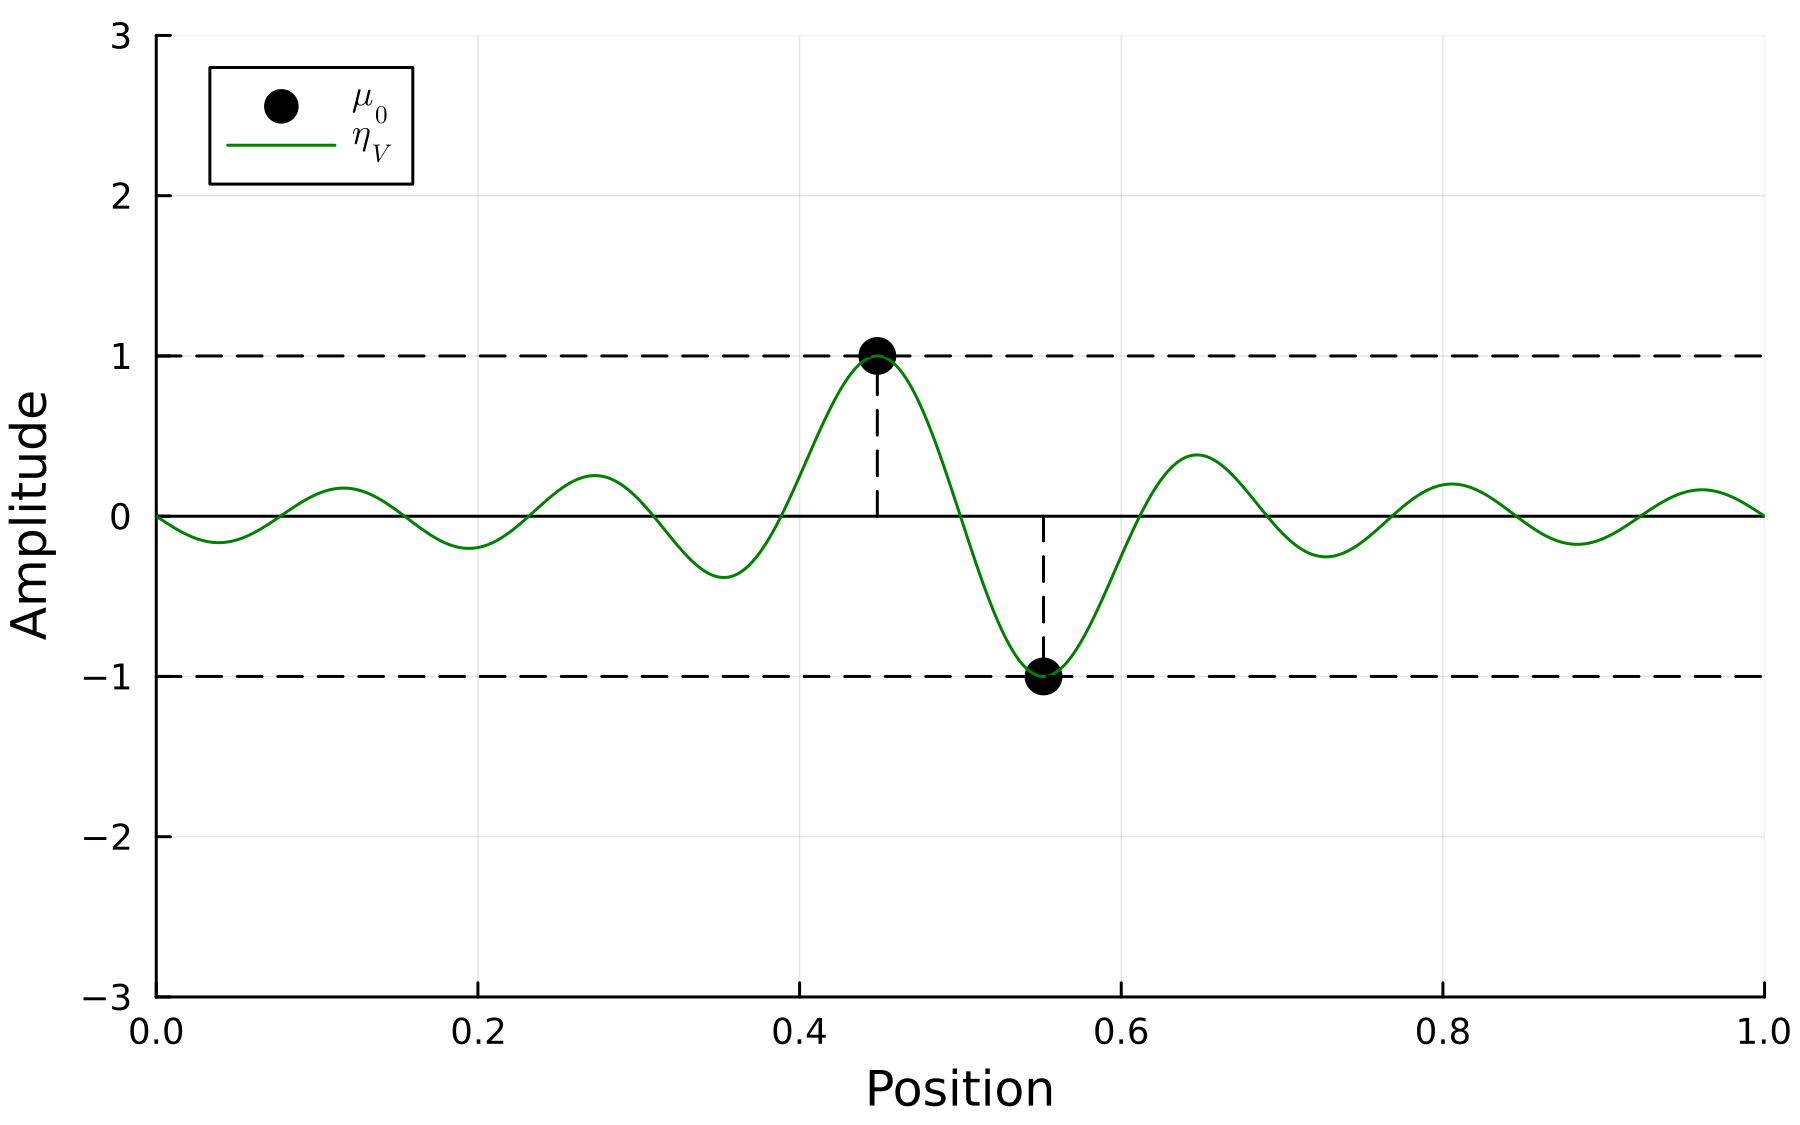

In [53]:
ηV = pre_certificate(μ0, ops)

plt_cert = deepcopy(plt)

plot!(plt_cert, plt_grid, ηV, label=L"η_V", color=:green)
hline!(plt_cert, [1, -1], linestyle=:dash, color=:black, label="")

## SDP

In [54]:
λ = 0

# y .+= randn(length(y)) * 0.1 * norm(y) / sqrt(length(y))

prob = BLASSO(y, ops, domain, λ)

prob_sdp = deepcopy(prob)

solve!(prob_sdp, :SDP)

Problem
  Name                   :                 
  Objective sense        : maximize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 262             
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 26              
  Matrix variables       : 1 (scalarized: 406)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - dual attempts          : 0        

BLASSO(ComplexF64[-3.7470027081099033e-16 - 0.5157471991678171im, 3.41740524767431e-16 + 0.5539399988846715im, -2.636779683484747e-16 - 0.5342664647994562im, 1.3877787807814457e-16 + 0.4587817568441746im, -8.326672684688674e-17 - 0.33537124765175896im, 0.0 + 0.17692679145550286im, 0.0 + 0.0im, 0.0 - 0.17692679145550286im, -8.326672684688674e-17 + 0.33537124765175896im, 1.3877787807814457e-16 - 0.4587817568441746im, -2.636779683484747e-16 + 0.5342664647994562im, 3.41740524767431e-16 - 0.5539399988846715im, -3.7470027081099033e-16 + 0.5157471991678171im], Operators(var"#ϕ#12"{Float64, UnitRange{Int64}}(0.2773500981126146, -6:6), var"#Φ#13"{var"#ϕ#12"{Float64, UnitRange{Int64}}}(var"#ϕ#12"{Float64, UnitRange{Int64}}(0.2773500981126146, -6:6)), var"#adjΦ#14"{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, var"#adjΦ#11#15"{var"#ϕ#12"{Float64, UnitRange{Int64}}}}(0.0:0.001:1.0, var"#adjΦ#11#15"{var"#ϕ#12"{Float64, UnitRange{Int64}}}(var"#ϕ#12"{Float6

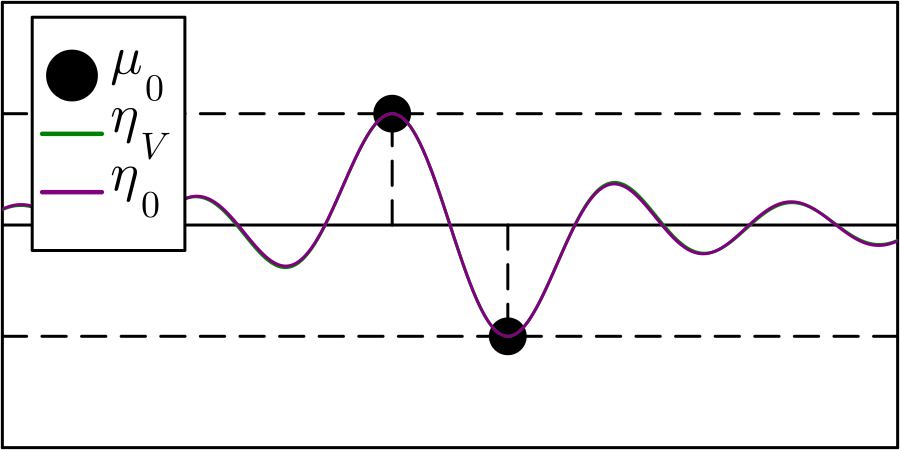

In [55]:
plt_sdp = deepcopy(plt_cert)

# dual polynomial
ηλ = ops.adjΦ(prob_sdp.p) * sqrt(n)
# plot!(plt_sdp, plt_grid, ηλ, label=L"η_λ", color=:purple)
plot!(plt_sdp, plt_grid, ηλ, label=L"η_0", color=:purple)
# hline!(plt_sdp, [1, -1], linestyle=:dash, color=:black, label="")
# plot!(plt_sdp, prob_sdp.μ.x, prob_sdp.μ.a, seriestype=:scatter, color=:red, label=L"μ_λ", marker=:x, markersize=10, markerstrokewidth=2)


using Plots.Measures
plot!(
    markerstrokewidth=0,
    xlabel="", ylabel="",
    legend=:topleft, legendfontsize=12,
    ticks=false, frame=:box,
    xlims=(0.1, 0.9), ylims=(-2, 2),margins=-1.8mm,
    size=(300,150))
    # size=plot_size ./ 1.5)

In [56]:
# savefig(plt_sdp, "../../figures/1D/CloseOpposite-$C.svg")

In [57]:
savefig(plt_sdp, "../../figures/PreCertificates/eta0eqetaV.svg")
# savefig(plt_sdp, "../../figures/PreCertificates/eta0neqetaV.svg")

"c:\\Users\\ladis\\OneDrive - University of Warwick\\Year 4\\Super resolution\\Codes\\SparseSpikes\\figures\\PreCertificates\\eta0eqetaV.svg"